# Import or Install Packages

In [1]:
! pip install xgboost

In [6]:
# Utilities
import os
from datetime import datetime
from tqdm.auto import tqdm
import warnings

# Data Handling
import numpy as np 
import pandas as pd
from sklearn import preprocessing

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Metrics and Validation
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

- **Set Up Options.**

In [7]:
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 100)

# Data Ingestion

In [8]:
# Kaggle Data
train_df_path = '/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv'
test_df_path = '/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv'
census_df_path = '/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv'
sub_file_path = '/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv'

# World Bank External Data
us_data_path = '/kaggle/input/world-data-bank/API_USA_DS2_en_excel_v2_4774388.csv'

In [9]:
train_df = pd.read_csv(train_df_path)
train_df = train_df.sort_values(by=['first_day_of_month']).reset_index(drop=True)
test_df = pd.read_csv(test_df_path)
test_df = test_df.merge(train_df[['cfips','county','state']].drop_duplicates().reset_index(drop=True), on='cfips')

# Data Preprocessing
### Data Findings:
- Start and End date for Train is **2019-08-01 to 2022-10-01.**
- Start and End date for Test  is **2022-11-01 to 2023-06-01.**
- A single **County** can have multiple **States.**
- Unique combination of **County** and **State** makes up a **Cfip**.
- Train and Test has exactly same amount of unique **Cfips**.

In [10]:
print(train_df.shape)
train_df.head(5)

(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,21153_2019-08-01,21153,Magoffin County,Kentucky,2019-08-01,0.336289,33
2,39057_2019-08-01,39057,Greene County,Ohio,2019-08-01,5.733927,7490
3,5063_2019-08-01,5063,Independence County,Arkansas,2019-08-01,1.865025,527
4,54021_2019-08-01,54021,Gilmer County,West Virginia,2019-08-01,0.526540,37


# Data Transformation
## Feature Engineering:

In [11]:
def dateEngg(df, date_col_name):
    df[date_col_name] = pd.to_datetime(df[date_col_name], format='%Y-%m-%d')
    df['year'] = df[date_col_name].dt.year
    df['month'] = df[date_col_name].dt.month
    #df['day_of_week'] = df[date_col_name].dt.day_of_week
    #df['day'] = df[date_col_name].dt.day
    #df['day_of_year'] = df[date_col_name].dt.day_of_year

In [12]:
for df in [train_df, test_df]:
    dateEngg(df,'first_day_of_month')

In [13]:
sel_columns_train = train_df.drop(['active', 'first_day_of_month'], axis=1).columns
sel_columns_test = train_df.drop(['active', 'first_day_of_month','microbusiness_density'], axis=1).columns

In [14]:
xgb_train = train_df[sel_columns_train]
xgb_test = test_df[sel_columns_test]

In [15]:
xgb_train.shape, xgb_test.shape

((122265, 7), (25080, 6))

# EDA

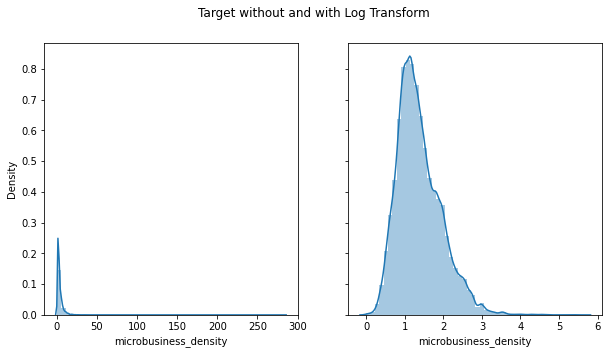

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Target without and with Log Transform')
sns.distplot(train_df['microbusiness_density'], ax=axes[0])
sns.distplot(np.log1p(train_df['microbusiness_density']), ax=axes[1]);

<AxesSubplot:xlabel='microbusiness_density'>

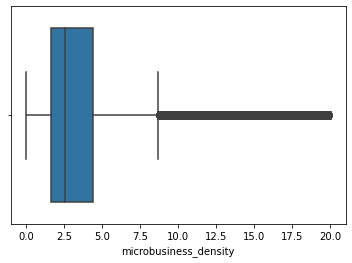

In [17]:
sns.boxplot(train_df[train_df['microbusiness_density']<20]['microbusiness_density'])

In [18]:
train_df['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

- **Label Encoding**

In [19]:
le = preprocessing.LabelEncoder()
for col in ['county','state']:
    le.fit(xgb_train[col].unique())
    for dfs in [xgb_train, xgb_test]:
        dfs[col] = le.transform(dfs[col])

# Metrics

In [20]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

Smape = make_scorer(smape)

# Modelling
## Xgboost
### Model Training Speed w.r.t different Accelerators.
- CPU         = 48 M/Min
- GPU T4 x2   = 124 M/Min 
- GPU P100    = 168 M/Min

## Model Utility

In [21]:
def get_best_model_name(x):
    cv_dict = {'LR':x[0],'SVR':x[1], 'RF':x[2], 'XGB':x[3]}
    min_cv = min(cv_dict.values())
    best_model_name = [key for key in cv_dict if cv_dict[key] == min_cv]
    return best_model_name[0]

### Get Cfip CV scores for all given Models
For a Cfip these are the steps:
- Get Train set X for CFIP.
- Get Train Y set.
- Create Test set X (8 months Nov-Jun).
- Concat both Train and Test and get Rolling mean for lag.
- Separate Train X and Test X sets.
- Train Model on Train set X, Y and Get predictions on Test X

In [ ]:
cfips_list = []
errors_list = []
for _,cfip in tqdm(xgb_train[['cfips']].drop_duplicates().iterrows(), total=len(xgb_train.cfips.unique())):
    currX = xgb_train[xgb_train['cfips']==cfip['cfips']][['year','month','microbusiness_density']]
    currX['MBD_RM_2'] = currX['microbusiness_density'].rolling(2).mean().bfill()
    p5, p95 = np.percentile(currX['microbusiness_density'], [5, 95])
    currX = currX[(currX['microbusiness_density']>=p5) & (currX['microbusiness_density']<=p95)]
    currY = currX['microbusiness_density']
    currX = currX[['year','month','MBD_RM_2']]
    model_dict = {}
    for model in [LinearRegression(), SVR(), RandomForestRegressor(), XGBRegressor(tree_method="gpu_hist")]:
        smape_score = cross_val_score(estimator= model, X=currX,
               y=currY, scoring=Smape, cv=5).mean()
        model_dict[type(model).__name__]=smape_score
    cfips_list.append(cfip['cfips'])
    errors_list.append(model_dict)

  0%|          | 0/3135 [00:00<?, ?it/s]

### Create a Dataframe with Best Model Selection

In [ ]:
LR_scores = []
SVR_scores = []
RF_scores = []
XGB_scores = []
for score_dict in errors_list:
    LR_scores.append(score_dict['LinearRegression'])
    SVR_scores.append(score_dict['SVR'])
    RF_scores.append(score_dict['RandomForestRegressor'])
    XGB_scores.append(score_dict['XGBRegressor'])
    
cfip_cv_score = pd.DataFrame({'Cfips':cfips_list,'LR':LR_scores,'SVR':SVR_scores,
                              'RF':RF_scores,'XGB':XGB_scores})

cfip_cv_score['Best_model']= cfip_cv_score[['LR','SVR','RF','XGB']].apply(get_best_model_name, axis=1)
cfip_cv_score['Best_score']= cfip_cv_score[['LR','SVR','RF','XGB']].apply(lambda x: min(x), axis=1)

In [ ]:
for res_col in cfip_cv_score.drop(['Cfips','Best_model'], axis=1):
    mean_cv = cfip_cv_score[res_col].mean()
    print(f'{res_col} CV = {mean_cv}')

In [ ]:
for i in range(20): 
    i_cv = cfip_cv_score[cfip_cv_score['Best_score']<=i]['Best_score'].mean()
    print(f'For Thres={i}, score={i_cv}')

# Get Predictions with Best Model and Some Preprocessing on Test set
For a Cfip these are the steps:
- Get Train set X for CFIP.
- Get Train Y set.
- Create Test set X (8 months Nov-Jun).
- Concat both Train and Test and get Rolling mean for lag.
- Separate Train X and Test X sets.
- Train Model on Train set X, Y and Get predictions on Test X

In [ ]:
# Cfips Empty List
cfips_predictions_dfs = []
# Model Dictionary
model_dict = {'LR':LinearRegression(), 'SVR':SVR(), 
                  'RF':RandomForestRegressor(), 'XGB':XGBRegressor(tree_method="gpu_hist")}

In [95]:
for _,cfip in tqdm(xgb_train[['cfips']].drop_duplicates().iterrows(), total=len(xgb_train.cfips.unique())):
    cfip = cfip['cfips']
    # Get Train X set.
    currX = xgb_train[xgb_train['cfips']==cfip][['year','month','microbusiness_density']]
    currX['Is_Test'] = 0
    # Get Test X set.
    currXT = test_df[['year', 'month']].drop_duplicates()
    currXT['Is_Test'] = 1
    # Combine Train X and Test X into a single Total Set.
    totalX = pd.concat([currX, currXT], axis=0, ignore_index=True)
    totalX['Index'] = range(0,47)
    # Get Rolling mean of two rows for Target
    totalX['MBD_RM_2'] = totalX['microbusiness_density'].rolling(2).mean().bfill()
    # Get Lagging Factor
    diff_lag_factor = (totalX['microbusiness_density'][35:39]-totalX['MBD_RM_2'][35:39]).mean()
    # Forward fill using previous two rows.
    for ind in range(0, 47):
        if pd.isnull(totalX['MBD_RM_2'][ind]):
            rm_ret = totalX[(totalX['Index']<ind) & (totalX['Index']>ind-3)]['MBD_RM_2'].mean()
            totalX.loc[ind,"MBD_RM_2"] = rm_ret-diff_lag_factor
        else:
            pass
    # Get Train X back.
    currX = totalX[totalX['Is_Test']==0][['year','month','MBD_RM_2','microbusiness_density']]
    # Get Test X back
    currXT = totalX[totalX['Is_Test']==1][['year','month','MBD_RM_2']]
    # Create row ID
    currXT['row_id'] = currXT[['year','month']].apply(lambda x: str(cfip)+'_'+str(x[0])+\
                                                  '-'+str(x[1]).zfill(2)+'-01', axis=1)
    # Trim data above 95 and below 5 percentiles.
    p5, p95 = np.percentile(currX['microbusiness_density'], [5, 95])
    currX = currX[(currX['microbusiness_density']>=p5) & (currX['microbusiness_density']<=p95)]
    # Get Train Y
    currY = currX['microbusiness_density']
    currX = currX[['year','month','MBD_RM_2']]
    
    best_model_name = cfip_cv_score[cfip_cv_score['Cfips']==cfip['cfips']]['Best_model'][0]
    best_model = model_dict[best_model_name]
    best_model.fit(currX, currY)
    best_preds = best_model.predict(currXT.drop('row_id', axis=1))
    currXT['microbusiness_density'] = best_preds
    cfip_pred_df = currXT[['row_id','microbusiness_density']]
    cfips_predictions_dfs.append(cfip_pred_df)